In [1]:
import warnings; warnings.simplefilter('ignore')

import torch
import os
import time
import itertools
import torch.nn as nn
from cell import graph_utils, utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph
from IPython.display import Image


os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import imp
from cell import  utils, analysis, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [105]:
def plot_grid(figsize, w_list, plot_dim):
    fig = plt.figure(figsize=figsize)
    i=1
    for w in w_list:
        filename = "w" + str(w) + "_" + str(plot_dim) + "d.csv"
        R = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/R_" + filename, index_col="Unnamed: 0")
        E = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/E_" + filename, index_col="Unnamed: 0")
        E.index = E.index.astype('str')
        R.index = R.index.astype('str')
        R = R.loc[[str(i) for i in range(1,R.shape[0]+1)]]
        E = E.loc[[str(i) for i in range(1,E.shape[0]+1)]]
        E['cluster_color'] = '#9FAAFF'
        R['cluster_color'] = '#D9F077'

        data = pd.concat([E, R])
        if plot_dim == 3:
            ax = fig.add_subplot(len(w_list), 3, i, projection="3d")
            ax.scatter(data['Z0'], data['Z1'], data['Z2'], color= data['cluster_color'], s=30)
            for j, txt in enumerate(data.index.tolist()):
                ax.text(data['Z0'][j], data["Z1"][j], data['Z2'][j], txt, size=10)
        else:
            ax = fig.add_subplot(len(w_list), 3, i)
            ax.scatter(data['Z0'], data['Z1'], color= data['cluster_color'], s=30)
            for j, txt in enumerate(data.index.tolist()):
                ax.text(data['Z0'][j], data["Z1"][j], txt, size=10)
        title = "w=" + str(w) 
        ax.set_title(title)
        i = i + 1

    plt.show()

In [112]:
def plot_nandcg_grid(plot_size, w_list, weight_mat, n_k, plot_dim):
    fig = plt.figure(figsize=figsize)
    i=1
    for w in w_list:
        filename = "w" + str(w) + "_" + str(plot_dim) + "d.csv"
        R = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/R_" + filename, index_col="Unnamed: 0")
        E = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/E_" + filename, index_col="Unnamed: 0")
        E.index = E.index.astype('str')
        R.index = R.index.astype('str')
        R = R.loc[[str(i) for i in range(1,R.shape[0]+1)]]
        E = E.loc[[str(i) for i in range(1,E.shape[0]+1)]]

        nandcg = []
        for n in range(1, n_k):
            s_to_t, t_to_s = analysis.return_right_left_similarity(E, R)
            nandcg.append(analysis.nandcg_score_at_k(s_to_t, np.array(weight_mat), k=n))
        ax = fig.add_subplot(len(w_list), 3, i)
        ax.scatter(range(1,n_k),nandcg)
        ax.plot(range(1,n_k),nandcg)
        ax.set_xlabel("rank")
        ax.set_ylabel("nandcg")
        title = "w=" + str(w) 
        ax.set_title(title)
        i = i + 1

    plt.show()

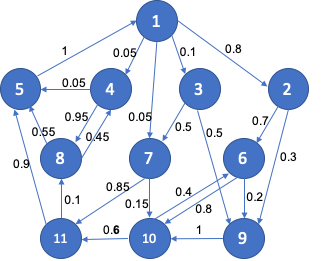

In [4]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=250, height=50)

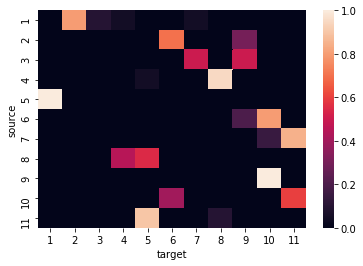

In [69]:
edges = pd.DataFrame([['1', '2', 0.8],
                      ['1', '3', 0.1],
                      ['1', '4', 0.05],
                      ['1', '7', 0.05],
                      ['2', '6', 0.7], 
                      ['2', '9', 0.3],
                      ['3', '9', 0.5],
                      ['3', '7', 0.5], 
                      ['4', '8', 0.95], 
                      ['4', '5', 0.05],
                      ['5', '1', 1], 
                      ['6', '9', 0.2], 
                      ['6', '10', 0.8],
                      ['7', '10', 0.15], 
                      ['7', '11', 0.85],
                      ['8', '5', 0.55],
                      ['8', '4', 0.45],
                      ['9', '10', 1], 
                      ['10', '11', 0.6], 
                      ['10', '6', 0.4],
                      ['11', '8', 0.1],
                      ['11', '5', 0.9]], columns=['source', 'target', 'weight'])

weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=True)
weight_mat = weight_mat.loc[[str(i) for i in range(1,12)]][[str(i) for i in range(1,12)]]
sns.heatmap(weight_mat)

In [70]:
weight_mat

target,1,2,3,4,5,6,7,8,9,10,11
source,,,,,,,,,,,
1,0.0,0.8,0.1,0.05,0.00,0.0,0.05,0.00,0.0,0.00,0.00
2,0.0,0.0,0.0,0.00,0.00,0.7,0.00,0.00,0.3,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.0,0.50,0.00,0.5,0.00,0.00
4,0.0,0.0,0.0,0.00,0.05,0.0,0.00,0.95,0.0,0.00,0.00
5,1.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
6,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.2,0.80,0.00
7,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.15,0.85
8,0.0,0.0,0.0,0.45,0.55,0.0,0.00,0.00,0.0,0.00,0.00
9,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,1.00,0.00


We performed, weighted directed walks from each node of the graph. From each node, 100 walks was initiated and the length of each walk was 100 steps. This walks were used to create a inputs to each arm of the following model:

In [7]:
walks = utils.read_list_of_lists_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_weighted_directed_footbal_v2.csv")

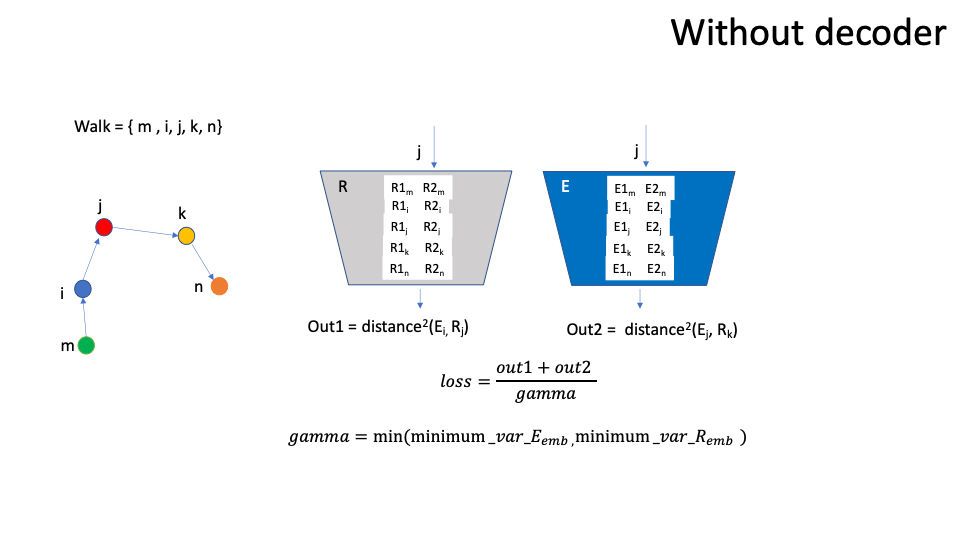

In [8]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/Encoder_only_model.png", width=1000, height=150)

We performed multiple different runs with different parameters. The following parameters were examined:
window size for choosing nodes before or after a certain node: w = {1, 2, 3}
embedding size: e:{2, 3, 5, 10}

In the following we will present the results of changing the above-mentioned parameters on the model accuracy. 

### Embedding size = 2 and we are changing the window size. 
#### Blue dots are Emitters and greens are receivers

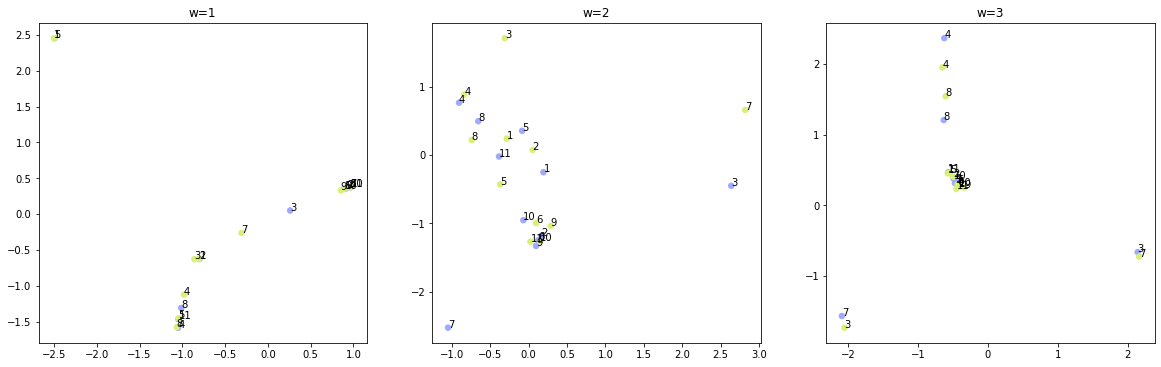

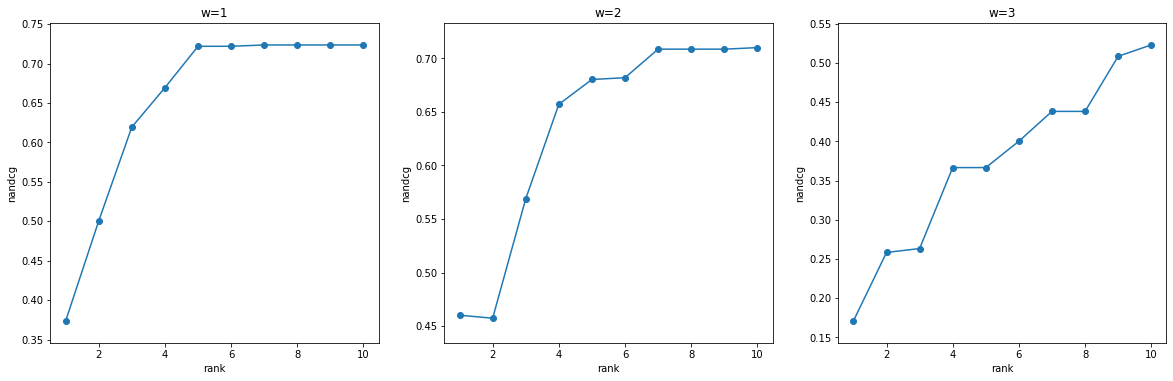

In [113]:
plot_grid(figsize=(20,20), w_list=[1, 2, 3], plot_dim=2)
plot_nandcg_grid(plot_size=(20,20), w_list=[1,2,3], weight_mat=weight_mat, n_k=11, plot_dim=2)

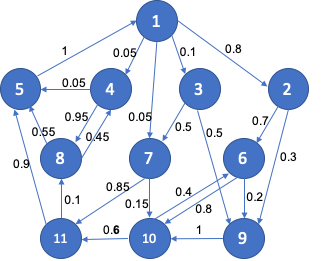

In [87]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=400, height=50)

### Embedding size = 3 and we are changing the window size 

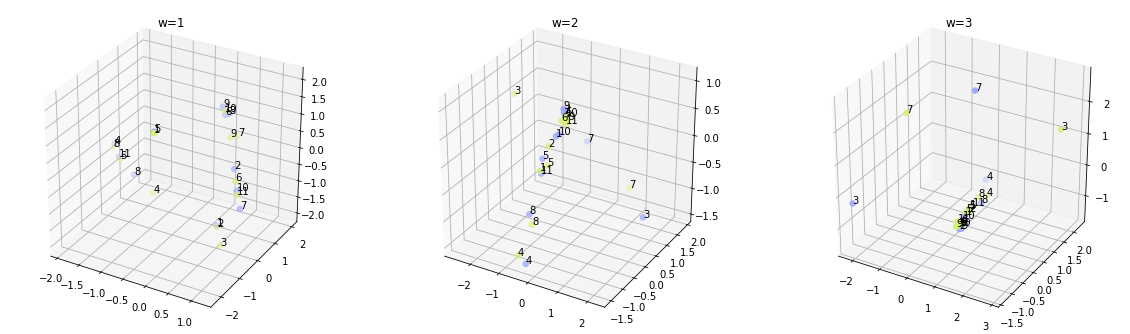

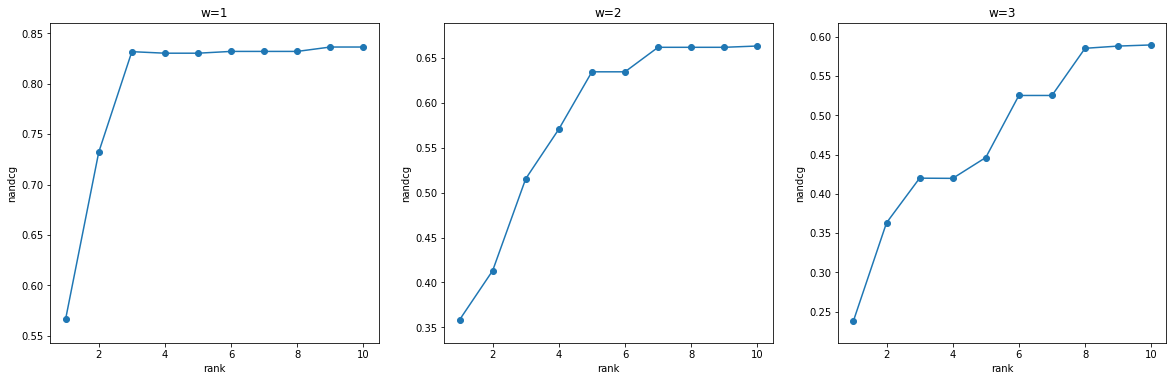

In [114]:
plot_grid(figsize=(20,20), w_list=[1, 2, 3], plot_dim=3)
plot_nandcg_grid(plot_size=(20,20), w_list=[1,2,3], weight_mat=weight_mat, n_k=11, plot_dim=3)

# NPP

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv
Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


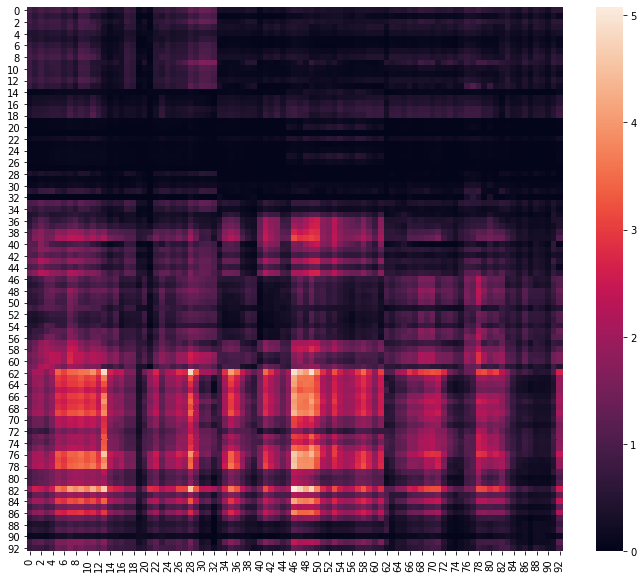

In [118]:
colors = utils.read_visp_npp_cldf()['cluster_color'].tolist()
types = utils.read_visp_npp_cldf()['cluster_label'].tolist()
layers = utils.get_npp_visp_layers()
total_inter = np.zeros((93,93))

for layer in layers:
    path = utils.get_npp_visp_interaction_mat_path(layer)
    tmp_inter= pd.read_csv(path, index_col="Unnamed: 0")
    total_inter = total_inter + tmp_inter.values
    
adj = total_inter.astype(float)
fig = plt.figure(figsize=(12,10))
sns.heatmap(adj)

We performed walk on this graph. From each node we start once and we walked 10000 steps